In [1]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import preprocessing

In [2]:
def showImage(image, cmap = None, window_name = None):
    plt.imshow(image, cmap = cmap)
    
    if window_name is not None:
        cv2.imshow(window_name, image)
        cv2.waitKey(0)
        cv2.destroyWindow(window_name)

___
# Generate Dataset

## Read Sample Image
Read sample image and then show it

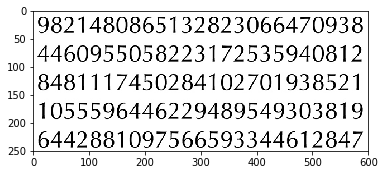

In [3]:
origin_image = cv2.imread("sample_ocr.png", cv2.IMREAD_GRAYSCALE)
process_image = origin_image.copy()
showImage(origin_image, cmap = 'gray')

## Prepare Sample
we start with blur the image to reduce noises and then extract texts from background

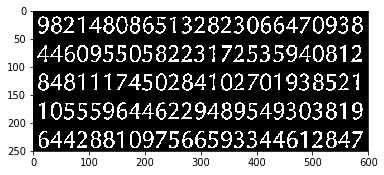

In [4]:
blur = cv2.GaussianBlur(process_image, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
showImage(thresh, cmap = 'gray')

## Assign Label
Assign Label to each sample by manually input

In [5]:
samples =  np.empty((0,100))
responses = []
keys = [i for i in range(48, 58)] #List of ASCII Code of number from 0 to 9

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    if cv2.contourArea(cnt) > 50: #check if each contour have area more than 50 pixel
        [x,y,w,h] = cv2.boundingRect(cnt) #get bounding board of the contour

        if  h>28:
            cv2.rectangle(process_image, (x, y),(x + w, y + h), (0, 0, 255), 2) #draw rectangle surround sample text
            roi = thresh[y : y + h, x : x + w] #extract each sample from processing image
            roismall = cv2.resize(roi,(10,10)) #resize sample to 10 x 10 pixels
            cv2.imshow('norm',process_image)
            key = cv2.waitKey(0) #wait untill user enter the sample label

            if key == 27:  # (escape to quit)
                cv2.destroyWindow("norm")
            elif key in keys:
                responses.append(int(chr(key))) #convert from ASCII Code to normal number and then add to label list
                sample = roismall.reshape((1,100))
                samples = np.append(samples, sample, 0) #add processed sample to dataset

responses = np.array(responses, np.float32) #convert label from int into float
responses = responses.reshape((responses.size, 1)) #reshape label to have only one column
print "assign complete"

cv2.destroyWindow("norm")

assign complete


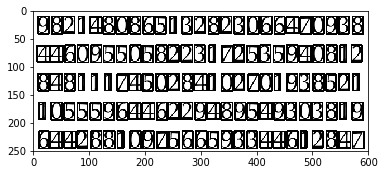

In [6]:
showImage(process_image, cmap = 'gray')

## Save the dataset

In [7]:
np.savetxt('generalsamples.data',samples)
np.savetxt('generalresponses.data',responses)

___
# Train

## Read Dataset 

In [9]:
read_samples = np.loadtxt('generalsamples.data',np.float32).reshape(125, 100)
read_labels = np.loadtxt('generalresponses.data',np.float32).reshape(125, 1)

In [10]:
encoder = preprocessing.OneHotEncoder()
encoder.fit(read_labels)
processed_labels = encoder.transform(read_labels).toarray()

## Show Example

Label = [ 9.]


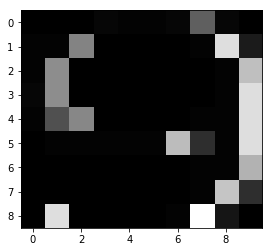

In [11]:
show = read_samples.reshape(10 * 125, 10)
showImage(show[124 * 10 : 124 * 10 + 9], cmap = 'gray')
print "Label =", read_labels[124]

In [12]:
with tf.name_scope('input'):
    # None -> batch size can be any size, 100 -> flattened mnist image
    x = tf.placeholder(tf.float32, shape=[None, 100], name="x-input") 
    # target 10 output classes
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

with tf.name_scope('weights'):
    W = tf.Variable(tf.zeros((100, 10))) #transposed weight matrix (10 set of weight)
    
with tf.name_scope('bias'):
    b = tf.Variable(tf.zeros(10)) #10 set of bias
    
with tf.name_scope('softmax'):
    evidence = tf.matmul(x, W) + b
    y = tf.nn.softmax(evidence)

with tf.name_scope('cross_Entropy'):
    cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y, 1e-10,1.0)), reduction_indices=[1]))

with tf.name_scope('gradient_descent'):
    gradient_descent = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
tf.summary.scalar("cost", cost)
tf.summary.scalar("accuracy", accuracy)
summary_op = tf.summary.merge_all()
    
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(5): # 5 epochs
    batch_xs = read_samples
    batch_ys = processed_labels
    sess.run([gradient_descent], feed_dict={x: batch_xs, y_: batch_ys})
print "done"
predicted = sess.run(y, feed_dict={x: read_samples})
print(sess.run(accuracy, feed_dict={x: read_samples, y_: processed_labels}))

done
0.84


# Test Model

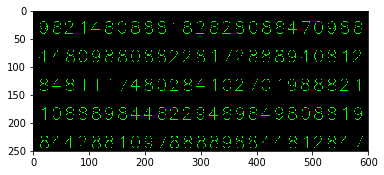

In [14]:
read_test = cv2.imread("sample_ocr.png")
test_image = cv2.cvtColor(read_test.copy(),cv2.COLOR_BGR2GRAY)
out = np.zeros_like(read_test)

thresh = cv2.adaptiveThreshold(test_image,255,1,1,11,2)

contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    if cv2.contourArea(cnt)>50:
        [x,y,w,h] = cv2.boundingRect(cnt)
        if  h>28:
            cv2.rectangle(read_test,(x,y),(x+w,y+h),(0,255,0),2)
            roi = thresh[y:y+h,x:x+w]
            roismall = cv2.resize(roi,(10,10))
            roismall = roismall.reshape((1,100))
            roismall = np.float32(roismall)
            predicted = sess.run(tf.argmax(tf.nn.softmax(tf.matmul(roismall, W) + b), axis=1))
            string = str(int(predicted))
            cv2.putText(out,string,(x,y+h),0,1,(0,255,0))

showImage(out)